In [6]:
import pandas as pd
#import pandas_profiling
#import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import  LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
import gc

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
df_cinemas=pd.read_csv("visitors_cinemas.csv",sep=';', index_col='SUBS_KEY',quoting = 1)
df_hs = pd.read_csv("data/HANDSET.csv",sep = ";", index_col='SUBS_KEY',quoting = 1)
df_dm = pd.read_csv("data/DM.csv",sep = ";",index_col='SUBS_KEY', low_memory = False, decimal =",",quoting = 1)
df_agg = pd.read_csv("data/AGG_sm.csv",sep = ";", quoting = 1)



In [4]:
# helper fuction to filetr AGG dataset
#df_agg[df_agg.index.isin(df_cinemas.index)].to_csv('data/AGG_sm.csv' ,sep =";", decimal =",", quoting = 1, encoding = 'utf-8') 
#gc.collect()
#del df_agg

In [8]:
#Проедобработка df_handsets
df_hs = df_hs[~df_hs.index.isnull()]
df_hs.index = df_hs.index.astype('int32')

num_col = [col for col, t in df_hs.dtypes.iteritems() if t != "object"]
cat_col = [col for col, t in df_hs.dtypes.iteritems() if t == "object"]

#заменяем пропущенные значения на "NA" для категориальных признаков
for col in cat_col:
    df_hs.loc[df_hs[col].isnull(), col] = "NA"

for col in num_col:
    df_hs.loc[df_hs[col].isnull(), col] = -1

df_hs.HANDSET_KEY = df_hs.HANDSET_KEY.astype('int32')
df_hs.IS_MULTISIM_IND = df_hs.IS_MULTISIM_IND.astype('int32')
    

In [9]:
#Проедобработка df_dm
df_dm = df_dm[~df_dm.index.isnull()]
df_dm.index = df_dm.index.astype('int32')


In [10]:
df_hs.head(5)

,HANDSET_KEY,HANDSET_VENDOR_CVAL,HANDSET_MODEL_CVAL,HANDSET_TYPE_CVAL,HANDSET_TECHNOLOGY_CVAL,IS_MULTISIM_IND
SUBS_KEY,,,,,,
12757,16443,Nokia,206,Feature+,2G,1
39077,16443,Nokia,206,Feature+,2G,1
31862,16443,Nokia,206,Feature+,2G,1
4019,16443,Nokia,206,Feature+,2G,1
25149,16443,Nokia,206,Feature+,2G,1


### Оценка  сбалансированности целевого значения

In [12]:
sum(df_cinemas.TARGET == 1)

10000

In [11]:
sum(df_cinemas.TARGET == 0)

10000

In [13]:
df_cinemas.shape[0]

20000

#### Выборка не скошена, можно использовать accuracy для теста

### Количество устройств по типам:

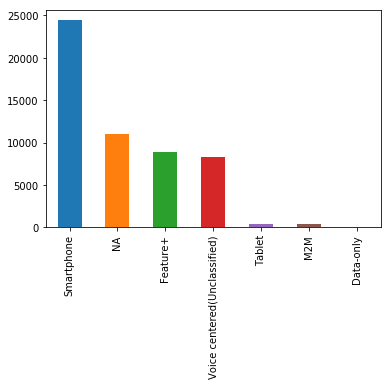

In [14]:
df_hs.HANDSET_TYPE_CVAL.value_counts().plot(kind='bar')

### Доля любителей кино в зависимости от типа устройства:

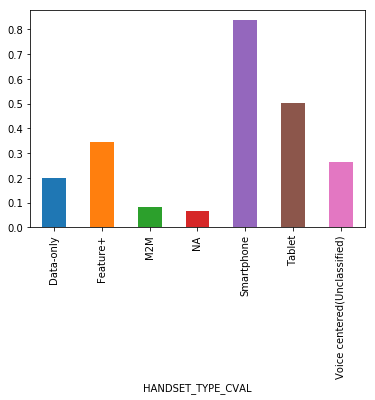

In [15]:
df = df_cinemas.join(df_hs, how="left", rsuffix="r1")
#группируем по типам и усредняем значение таргета
df.groupby("HANDSET_TYPE_CVAL")['TARGET'].mean().plot(kind='bar')

Видно что более 80% пользователий  смартфонов - любители кино. 

### Любители кино по моделям телефонов:

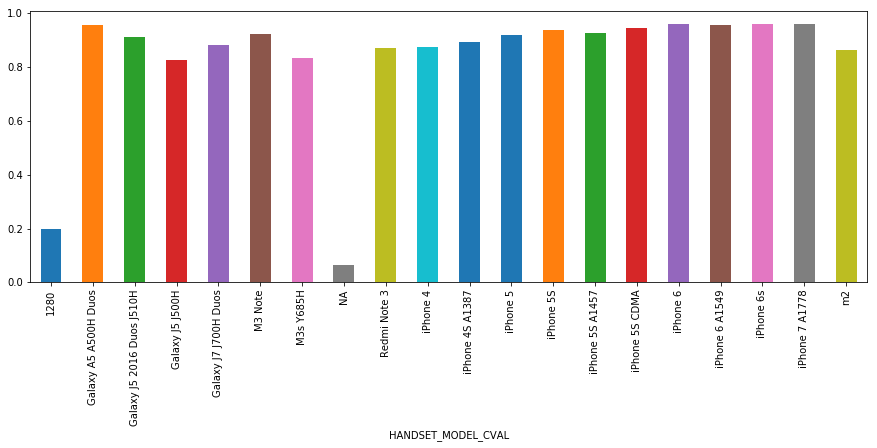

In [16]:
plt.figure(figsize(15,5))
# будем строить визуализацию только по популярным моделям
top_models = df.HANDSET_MODEL_CVAL.value_counts()
df[df.HANDSET_MODEL_CVAL.isin(top_models[:20].index)].groupby("HANDSET_MODEL_CVAL")['TARGET'].mean().plot(kind='bar')

Чем дороже телефон тем больше любителей кино среди его владельцев

In [ ]:
# мода по пилону
from scipy.stats.mstats import mode
df_agg.SUBS_KEY = df_agg.SUBS_KEY.astype('int64')
f = lambda x: mode(x, axis=None)[0]
pilons_moda = df_agg.groupby('SUBS_KEY')['PYLON_KEY'].apply(f)

### Add info from the financial data table (DM)

In [17]:
df = df.join(df_dm[df_dm.MONTH_DT == '01.03.2017'], how="left", rsuffix="r2")
#выделяем таргет и дропаем ненужную больше нам дату
target = df.TARGET
df.drop(["MONTH_DT"], axis = 1,  inplace = True)

### Add info from the table of base stations

In [18]:
f2 = lambda x: x.idxmax()
grouped_indx = df_agg.groupby(['SUBS_KEY'])['EVENT_CNT'].apply(f2).reset_index()
df_agg_by_events = df_agg.loc[df_agg.index.isin(grouped_indx['EVENT_CNT'])].set_index('SUBS_KEY')
df = df.join(df_agg_by_events['BASE_STATION_KEY'], how="left", rsuffix="r3")

### Filling NA values, coding of categorical features

In [29]:
#кодируем категориальные фичи числовыми значениями.
#Поскольку будем применят деревья, onehot encoding не делаем

cat_col_transformed = []
enc = LabelEncoder()
for col in cat_col:
    col_traisformed = col + '_tr'
    df[col_traisformed] = enc.fit_transform(df[col])
    cat_col_transformed.append(col_traisformed)
    

In [27]:
#num_col - числовые фичи
#сat_col - категориальные фичи
num_col = [col for col, t in df.dtypes.iteritems() if t!="object"]
cat_col = [col for col, t in df.dtypes.iteritems() if t=="object"]
for col in cat_col:
    df.loc[df[col].isnull(), col] = "NA"

for col in num_col:
    df.loc[df[col].isnull(), col] = -1

num_col.remove('TARGET')

## Feature importances

In [30]:
train_features = num_col + cat_col_transformed
train_features.remove('HANDSET_MODEL_CVAL_tr')
train_features.remove('HANDSET_VENDOR_CVAL_tr')

rf =  RandomForestClassifier(n_estimators=200)
model= rf.fit(df[train_features],target)
d = {key:value for key, value in zip(train_features, model.feature_importances_)}
feat_importance = sorted(d.items(), key=lambda x: x[1], reverse = True)
feat_importance[:50]


[('TOTAL_SMS_REVENUE', 0.079166237268236267),
 ('INTERNATIONAL_SMS_REVENUE', 0.075985540193872034),
 ('OFF_NET_INCOMING_CALLS_MIN', 0.054387163283542227),
 ('TOTAL_ITC_REVENUE', 0.040788919757871245),
 ('OFF_NET_ITC_REVENUE', 0.039179101592682015),
 ('DISTRICT', 0.039047563621375431),
 ('OFF_NET_INCOMING_CALLS_COUNT', 0.037024737981358753),
 ('TOTAL_INCOMING_CALLS_MIN', 0.035157171518939843),
 ('PREFFERED_LOCATION_REGION', 0.032945084259374931),
 ('OFF_NET_SMS_REVENUE', 0.032713656798362176),
 ('TOTAL_INCOMING_CALLS_COUNT', 0.029992986716121769),
 ('ON_NET_INCOMING_CALLS_COUNT', 0.026592837593876439),
 ('BASE_STATION_KEY', 0.024834515674336942),
 ('HANDSET_KEY', 0.018487556674133616),
 ('HANDSET_TECHNOLOGY_CVAL_tr', 0.018051790536004253),
 ('HANDSET_TYPE_CVAL_tr', 0.018027746744464564),
 ('TOTAL_ITC_COST', 0.016464887117173057),
 ('VOICE_OFF_NET_IND', 0.014405236454265306),
 ('TOTAL_OUTGOING_CALLS_MIN', 0.014070492060481778),
 ('ON_NET_INCOMING_CALLS_MIN', 0.013846277767099447),
 ('MOB

In [20]:
df.DISTRICT.nunique()

464

In [21]:
district_df = df.groupby("DISTRICT")['TARGET'].mean()
district_df[district_df > 0.75].count()

17

Видим, что есть 17 районов где любителей кино > 75%

### Основной вывод - факт "Ходит ли абонент в кино" коррелирует с его финансовым положением. Финансовое положение определяется рядом фич.

In [33]:
train_cols = [c[0] for c in feat_importance]
#prediction by Random forest
X_train, X_test, y_train, y_test = train_test_split(df[train_cols[:30]], target, 
                                                    test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=200)

model = clf.fit(X_train, y_train) 

predict = clf.predict(X_test)
print(accuracy_score(predict,y_test))


0.9145


In [34]:
#prediction by Gradient Boosting
clf = GradientBoostingClassifier(n_estimators = 200,)
model = clf.fit(X_train, y_train) 

# to estimate best numbers of trees
scores = [accuracy_score(predict,y_test) for predict in clf.staged_predict(X_test)]
    
best_tree_num = np.argmax(scores) + 1
max_score = np.max(scores)
print("Best Score = {}, at tree number = {}".format(max_score, best_tree_num))




Best Score = 0.9148333333333334, at tree number = 186


### Model serialize

In [ ]:
pickle.dump(model, open('model.pcl',"wb"))
pickle.dump(df[train_cols[:30]], open('df.pcl','wb'))

In [80]:
def calculate_confusions(categ1,categ2):
    list1 = df[categ1].unique()
    list2 = df[categ2].unique()
    confusions = []
    for v1 in list1:
        for v2 in list2:
            sum1 = 0
            cond = (df[categ1] == v1) & (df[categ2] == v2)
            confusions.append(cond.sum())
    confusion_matrix = np.array(confusions).reshape(len(list1), len(list2))
    return confusion_matrix

In [81]:
#confusion_matrix = calculate_confusions('BASE_STATION_KEY','DISTRICT')
confusion_matrix = pd.crosstab(df['BASE_STATION_KEY'], df['DISTRICT'])

In [69]:
confusion_matrix

DISTRICT,-1.0,1.0,5.0,12.0,15.0,16.0,17.0,18.0,19.0,20.0,...,481.0,482.0,483.0,484.0,485.0,486.0,487.0,488.0,489.0,490.0
BASE_STATION_KEY,,,,,,,,,,,,,,,,,,,,,
-1.0,4019,2,1,3,0,2,20,2,2,2,...,0,1,0,0,0,0,0,0,6,0
1782.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1822.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1825.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1846.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1854.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1858.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1869.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1890.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Trying to calculate Cramer V statistic to estimate correlation betwin categ. feature (not working)

In [82]:
import scipy.stats as ss
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [83]:
cramers_corrected_stat(confusion_matrix)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [87]:
import scipy.stats as ss

def cramers_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

result = cramers_stat(confusion_matrix)

In [ ]:
import scipy.stats as ss

def cramers_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

result = cramers_stat(confusion_matrix)